<a href="https://colab.research.google.com/github/ishnt/Projects-and-Coursework/blob/main/GANime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d quadeer15sh/celeba-face-recognition-triplets

 97% 381M/395M [00:05<00:00, 29.0MB/s]
100% 395M/395M [00:05<00:00, 79.9MB/s]


In [ ]:
!unzip animefacedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [ ]:
import os
import glob

# Define the folder path where the .png files are located
folder_path = '/content/images'

# Change directory to the folder containing the images
os.chdir(folder_path)

# Use glob to find all .png files in the folder
png_files = glob.glob('*.png')

# Specify the number of files to delete
num_files_to_delete = 58000

# Counter for deleted files
deleted_count = 0

# Loop through the .png files and delete them
for file in png_files:
    if deleted_count < num_files_to_delete:
        os.remove(file)
        deleted_count += 1
        print(f"Deleted file: {file}")
    else:
        break

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from IPython import display

In [ ]:
root_path = "/content/images"
root_path = pathlib.Path(root_path)

In [ ]:
# prepraing data
batch_size = 32

data = keras.utils.image_dataset_from_directory(
    directory=root_path,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64,64))


Found 63565 files belonging to 1 classes.


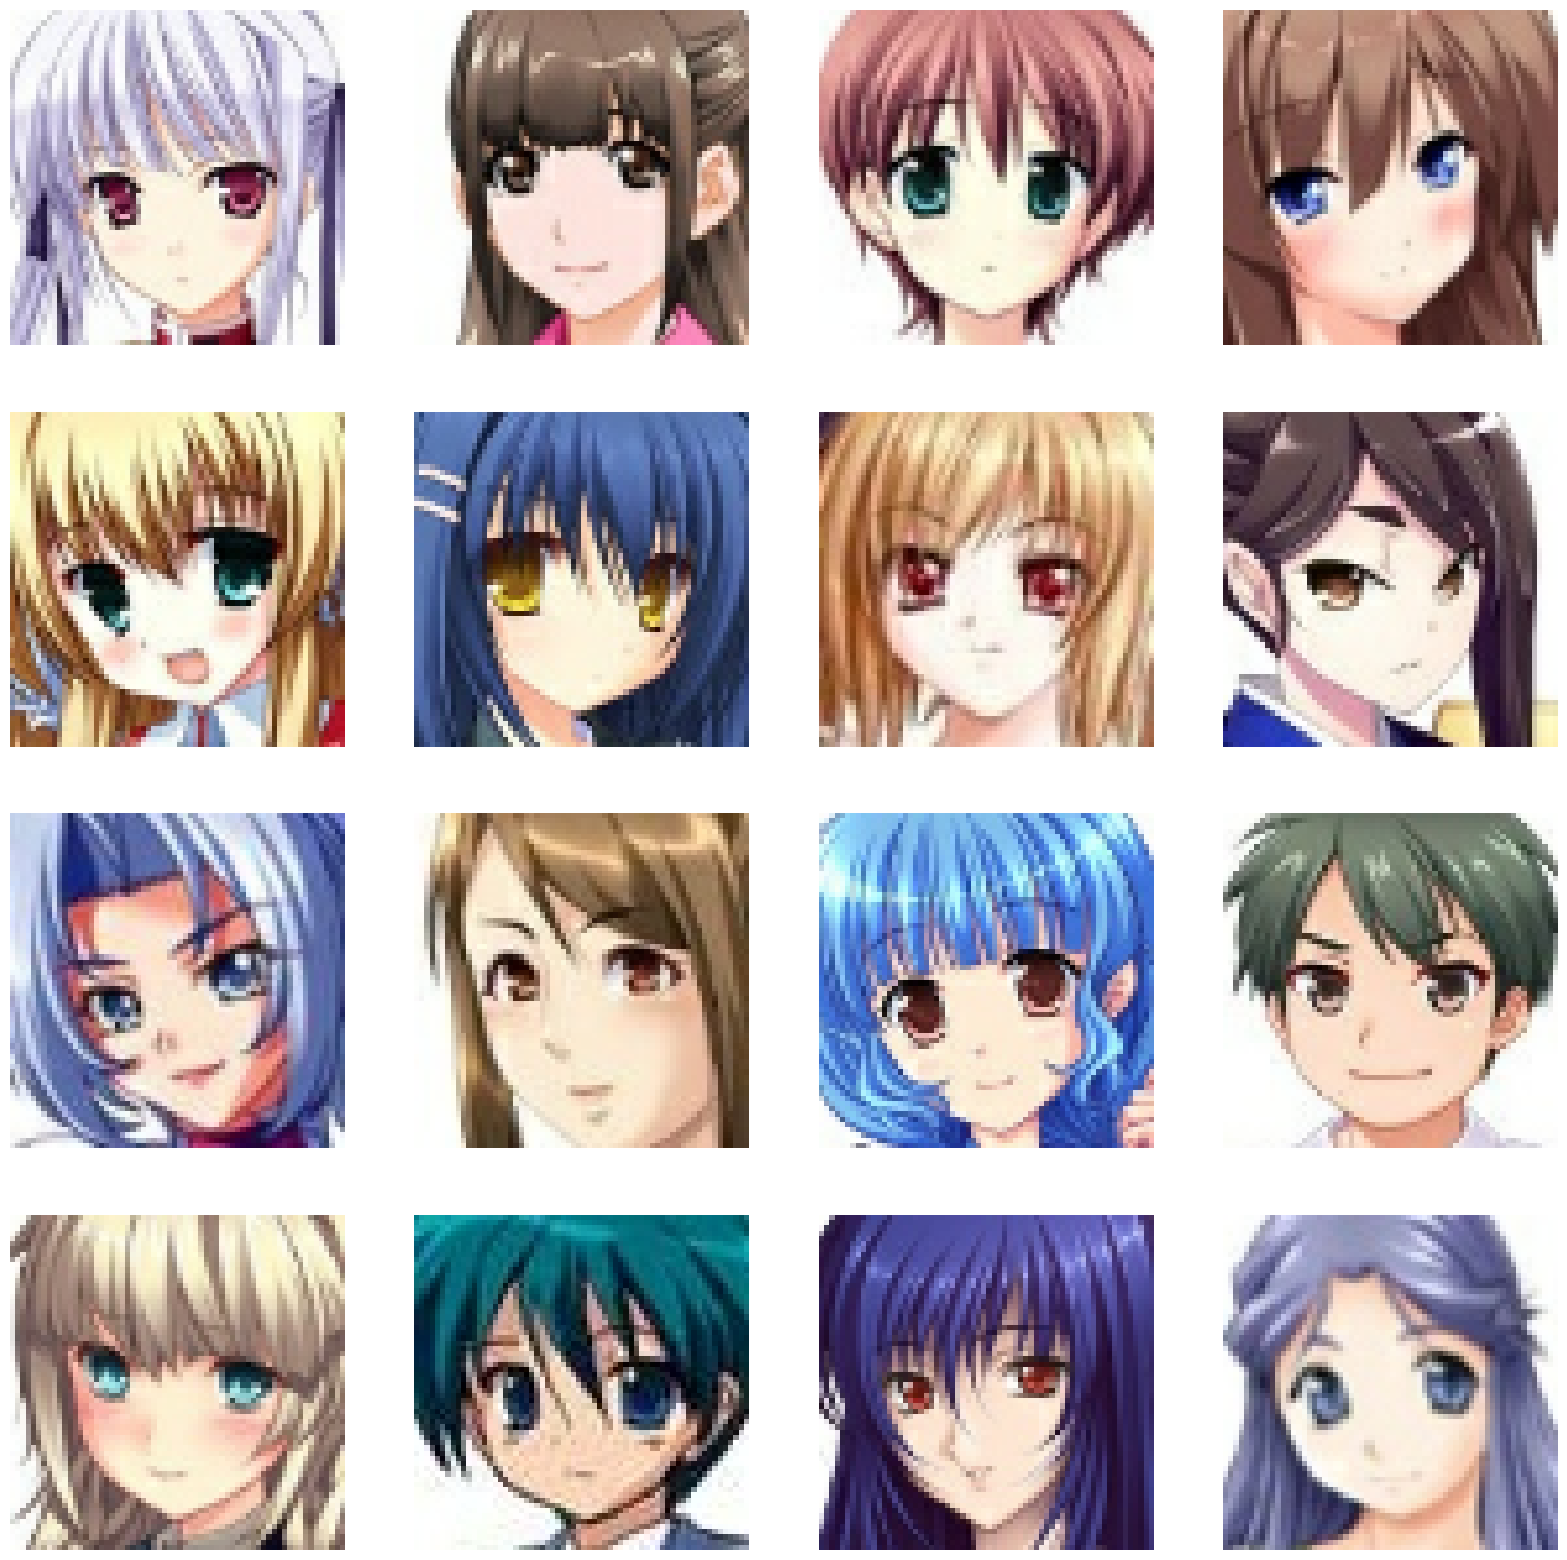

In [ ]:
# let's see some images of the dataset
plt.figure(figsize=(20,20))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# normalizing the input image to the range [-1, 1]
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
# Discriminator
def Discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU", input_shape=(64,64,3)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator

D_model = Discriminator()
D_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0

In [ ]:
# optimizer
D_optm = Adam(1e-4)

In [ ]:
latent_dim = 100

In [ ]:
# Build the Generator function
def Generator():
  generator = Sequential()
  generator.add(Dense(units=4*4*256, input_shape =[latent_dim], use_bias=False))
  generator.add(Reshape((4,4,256)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="tanh"))

  return generator


# a summary of the Generetor
G_model = Generator()
G_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              409600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 256)         1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         295040    
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 128)         512       
 chNormalization)                                                
                                                      

In [ ]:
# optimizer
G_optm = Adam(1e-4)

(-0.5, 63.5, 63.5, -0.5)

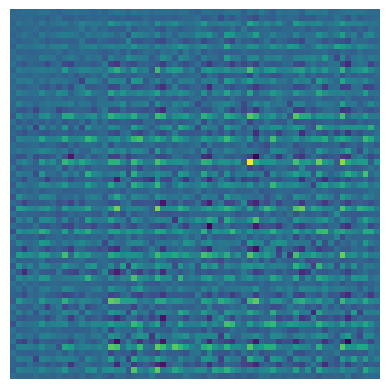

In [ ]:
# creating random noise
random_noise = tf.random.normal([1,latent_dim])
# feeding random noise to Genereator
G_output_on_random_noise = G_model(random_noise, training=False)
# showing the image output of G_model
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")

In [ ]:
# feeding the output of Generator to Discriminator
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.5000407]], shape=(1, 1), dtype=float32)


In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [ ]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [ ]:
# number of epochs
epochs = 10
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/10
1987/1987 [==============================] - 70s 31ms/step - d_loss: 0.1819 - g_loss: 95.6175
Epoch 2/10
1987/1987 [==============================] - 60s 30ms/step - d_loss: 0.1811 - g_loss: 4.8190
Epoch 3/10
1987/1987 [==============================] - 61s 31ms/step - d_loss: 0.2193 - g_loss: 3.6442
Epoch 4/10
1987/1987 [==============================] - 60s 30ms/step - d_loss: 0.2370 - g_loss: 3.6570
Epoch 5/10
1987/1987 [==============================] - 59s 30ms/step - d_loss: 0.2426 - g_loss: 3.2690
Epoch 6/10
1987/1987 [==============================] - 60s 30ms/step - d_loss: 0.2558 - g_loss: 3.1846
Epoch 7/10
1987/1987 [==============================] - 61s 30ms/step - d_loss: 0.2596 - g_loss: 2.9273
Epoch 8/10
1987/1987 [==============================] - 61s 31ms/step - d_loss: 0.2803 - g_loss: 2.7914
Epoch 9/10
1987/1987 [==============================] - 61s 31ms/step - d_loss: 0.2877 - g_loss: 2.7555
Epoch 10/10
1987/1987 [==============================] - 60s 30

In [ ]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model
generated_images = G_model(noise, training=False)

In [ ]:
# converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5

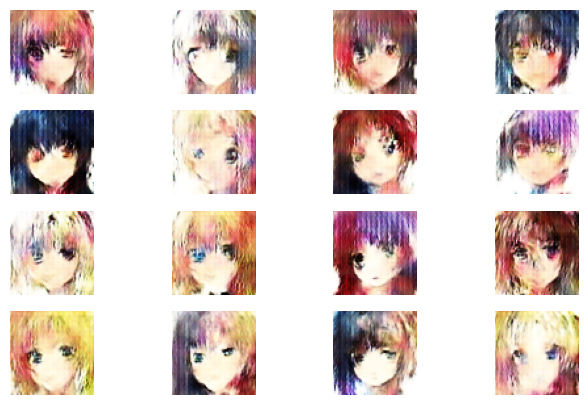

In [ ]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()